In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
engine = create_engine("sqlite:///hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

##### Calculate the date 1 year ago from the last data point in the database

In [5]:
#Last date in database
last_date=session.query(func.max(Measurement.date)).first()
last_date

('2017-08-23')

#### Calculate the date 1 year ago from the last data point in the database

In [6]:
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year

datetime.date(2016, 8, 23)

### Loading data to Pandas dataframe

In [7]:
# Perform a query to retrieve the data and precipitation scores
rain=session.query(Measurement.date,Measurement.prcp).\
        filter(Measurement.date>=last_year).\
        order_by(Measurement.date) # Sort the dataframe by date
rain_df=pd.DataFrame(rain) # Save the query results as a Pandas DataFrame 
rain_df.set_index('date').head() #and set the index to the date column

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


#### Plotting

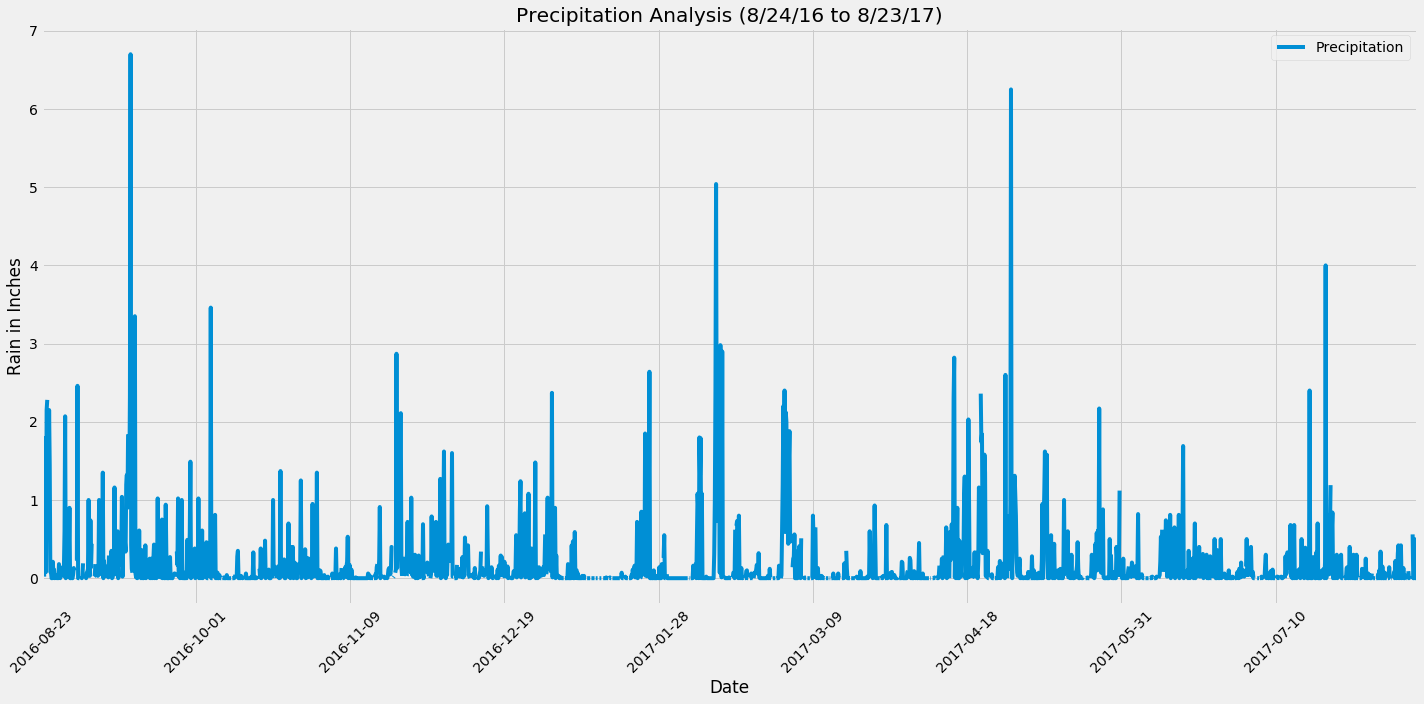

In [8]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.style as style
style.use('fivethirtyeight')
rain_df.plot('date', 'prcp',figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



#### Use Pandas to calculate the summary statistics for the precipitation data

In [9]:
rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
'''Calculate the rainfall per weather station using the previous year's matching dates'''
year = dt.timedelta(days=365)
#choose a start and end date for the trip
trip_start = dt.date(2018,7,3)
trip_end = dt.date(2018,7,17)

#find the matching dates from the previous year 
prv_start = trip_start - year
prv_end = trip_end - year

#make the query
prcp_stn = session.query(msmt.station, msmt.prcp).filter(msmt.date >= prv_start).\
                        filter(msmt.date <= prv_end).group_by(msmt.station).all()

#make the df    
prcp_stn_df = pd.DataFrame(prcp_stn, columns = ['Station', 'Precipitation Totals'])

NameError: name 'msmt' is not defined

# Station Analysis
#### Design a query to show how many stations are available in this dataset?

In [10]:
station_number=session.query(Station.name).count()
print(f"there are {station_number} stations in this dataset")

there are 9 stations in this dataset


#### Design a query to find the most active stations.

In [11]:
stations=session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc())
busiest_station=stations[0][0]
busiest_count=stations[0][1]
# What are the most active stations? (i.e. what stations have the most rows)?
print(f"{busiest_station} is the busiest station with {busiest_count} observations")
print("-------------------------------------------------------")
# List the stations and the counts in descending order.
for station, count in stations:
    print(f"Station {station} had {count} number of observations")

USC00519281 is the busiest station with 2772 observations
-------------------------------------------------------
Station USC00519281 had 2772 number of observations
Station USC00519397 had 2724 number of observations
Station USC00513117 had 2709 number of observations
Station USC00519523 had 2669 number of observations
Station USC00516128 had 2612 number of observations
Station USC00514830 had 2202 number of observations
Station USC00511918 had 1979 number of observations
Station USC00517948 had 1372 number of observations
Station USC00518838 had 511 number of observations


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded
# highest temperature recorded, and average temperature most active station?
temperatures=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))
for min, max, avg in temperatures:
    print (min,max,avg)

53.0 87.0 73.09795396419437


In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_station=session.query(Measurement.station,Measurement.date,Measurement.tobs).\
    filter(Measurement.station==busiest_station).\
    filter(Measurement.date>=last_year).order_by(Measurement.date).all()

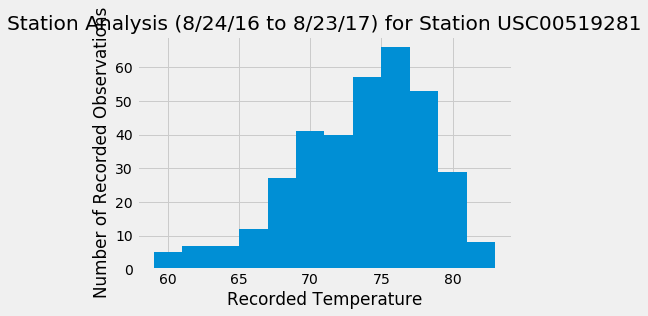

In [15]:
temp_df=pd.DataFrame(highest_station)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest_station)
plt.show()

# Temperature Analysis

In [16]:
#write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
    #and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_dt, end_dt):
    temps = session.query(func.min(msmt.tobs), func.avg(msmt.tobs), func.max(msmt.tobs)).\
                          filter(msmt.date >= start_dt).filter(msmt.date <= end_dt).all()
    
    #pull out the values
    tmp_min, tmp_avg, tmp_max = temps[0]
    
    #return a list
    return [('Trip Min Temp', tmp_min), ('Trip Avg Temp', tmp_avg), ('Trip Max Temp', tmp_max)]

#calculate the min, avg, and max temperatures using the previous year's matching dates 
temps_list = calc_temps(prv_start, prv_end)

#make a df
temps_df = pd.DataFrame(temps_list, columns = ['Title', 'Temp (F)'])

#make sure it's in order
temps_df.sort_values(by=['Temp (F)'])

#calculate the yerr (tmp_max - tmp_min)
max_min = temps_df.iloc[2][1] - temps_df.iloc[0][1]
max_min

'''Plot the min, avg, and max temperature from your previous query as a bar chart'''

#make the font scale larger
sns.set(font_scale=1.5)

#set the plot size
plt.figure(figsize=(4,9))

#plot
sns.barplot(x='Title', y='Temp (F)', data=temps_df.iloc[1:2], color='cyan', 
                  yerr=max_min, edgecolor='k', linewidth=1)

#make the title
plt.title(f'Temps from {prv_start} to {prv_end}')
          

#remove the x label
plt.xlabel('')
plt.show()

NameError: name 'prv_start' is not defined